# Customer Service Queueing Simulation

## Problem Formulation

### Fax Processing System Description

#### Stage 1: Entry Agents
- **Arrival Process**: Faxes arrive at rate $\lambda$ (Poisson distributed)
- **Service Process**: Entry agents handle faxes with mean service time $\mu_1^{-1} = 2.5$ minutes 
- **Routing Decision**: After processing, faxes are classified as:
  - Simple (80%): Work completed
  - Complex (20%): Requires specialist

#### Stage 2: Specialists
- **Arrival Process**: $p \cdot \lambda$ where $p = 0.2$ (20% of processed faxes from Stage 1)
- **Service Process**: Specialists handle complex faxes with mean service time $\mu_2^{-1} = 4.0$ minutes

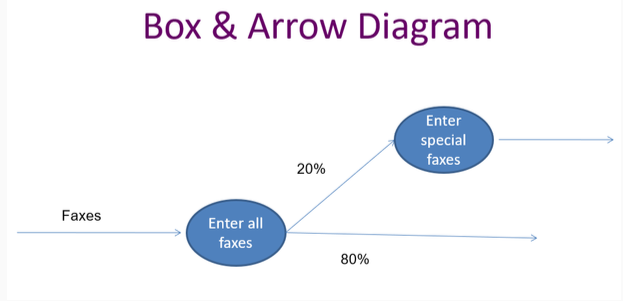

### Model

#### Parameters
- $\lambda$: Fax arrival rate (faxes/minute)
- $n_1$: Number of entry agents
- $n_2$: Number of specialists
- $\mu_1$: Entry agent service rate ($1/2.5$ $\min^{-1}$)
- $\mu_2$: Specialist service rate ($1/4.0$ $\min^{-1}$)
- $p$: Probability of requiring specialist ($p = 0.2$)

#### Queueing Stability Conditions
For system stability, we require:
- **Entry stage**: $\rho_1 = \frac{\lambda}{n_1 \mu_1} < 1 \Rightarrow n_1 > \frac{\lambda}{\mu_1}$
- **Specialist stage**: $\rho_2 = \frac{p\lambda}{n_2 \mu_2} < 1 \Rightarrow n_2 > \frac{p\lambda}{\mu_2}$

#### Service Level Requirements
1. **Simple Orders**: $P(T_{simple} \leq 10) \geq 0.96$
2. **Complex Orders**: $P(T_{complex} \leq 10) \geq 0.80$

#### Decision Variables
- $n_1$: Number of entry agents to staff
- $n_2$: Number of specialists to staff

#### Objective Function
Minimize total staffing cost while meeting service level agreements:
$$\begin{align}
\text{minimize:} \quad & c_1 \cdot n_1 + c_2 \cdot n_2 \\
\text{subject to:} \quad & P(T_{simple} \leq 10) \geq 0.96 \\
& P(T_{complex} \leq 10) \geq 0.80 \\
& n_1 > \frac{\lambda}{\mu_1}, \quad n_2 > \frac{p\lambda}{\mu_2}
\end{align}$$
When setting $c_1 = c_2 = 1$, our final target is to find the minimal required staff numbers.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dataclasses import dataclass
from typing import Tuple, Dict, List
from enum import Enum
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## System Parameters Configuration

Here we define all system parameters in a centralized location, making it easy to modify any aspect of our queueing system. The dataclass structure provides type safety and validation. We also include functions to check queueing stability - a fundamental requirement that ensures queues don't grow without bound. For our two-stage system, stability requires that arrival rates don't exceed service capacity at each stage.


In [57]:
@dataclass
class SystemParameters:
    """System parameters with queueing stability analysis"""
    
    # Arrival parameters
    arrival_rate: float = 45/15  # λ: faxes per minute (45 faxes in 15 minutes)
    simulation_time: float = 15.0  # minutes
    
    # Service parameters with distribution support
    entry_service_mean: float = 2.5  # μ₁⁻¹: minutes
    entry_service_variability: float = 0.2  # coefficient of variation
    entry_service_distribution: DistributionType = DistributionType.NORMAL
    
    specialist_service_mean: float = 4.0  # μ₂⁻¹: minutes
    specialist_service_variability: float = 0.2  # coefficient of variation
    specialist_service_distribution: DistributionType = DistributionType.NORMAL
    
    # Routing parameters
    specialist_probability: float = 0.2  # p: probability requiring specialist
    
    # Service level targets
    simple_sla_target: float = 0.96  # 96% within SLA time
    complex_sla_target: float = 0.80  # 80% within SLA time
    sla_time_limit: float = 10.0  # minutes
    
    # Staffing costs
    entry_agent_cost: float = 1.0
    specialist_cost: float = 1.5
    
    # Backward compatibility properties
    @property
    def entry_service_std(self) -> float:
        return self.entry_service_mean * self.entry_service_variability
    
    @property
    def specialist_service_std(self) -> float:
        return self.specialist_service_mean * self.specialist_service_variability
    
    def __post_init__(self):
        """Parameter validation"""
        if self.arrival_rate <= 0:
            raise ValueError("Arrival rate λ must be positive")
        if not (0 <= self.specialist_probability <= 1):
            raise ValueError("Specialist probability p must be in [0,1]")
    
    def get_expected_arrivals(self) -> float:
        """Expected arrivals: E[N] = λT"""
        return self.arrival_rate * self.simulation_time
    
    def get_specialist_arrival_rate(self) -> float:
        """Specialist arrival rate: λ₂ = pλ"""
        return self.arrival_rate * self.specialist_probability
    
    def get_entry_service_rate(self) -> float:
        """Entry service rate: μ₁ = 1/E[S₁]"""
        return 1.0 / self.entry_service_mean
    
    def get_specialist_service_rate(self) -> float:
        """Specialist service rate: μ₂ = 1/E[S₂]"""
        return 1.0 / self.specialist_service_mean
    
    def get_minimum_entry_agents(self) -> float:
        """Minimum entry agents for stability: n₁ > λ/μ₁"""
        return self.arrival_rate / self.get_entry_service_rate()
    
    def get_minimum_specialists(self) -> float:
        """Minimum specialists for stability: n₂ > pλ/μ₂"""
        return self.get_specialist_arrival_rate() / self.get_specialist_service_rate()
    
    def is_stable(self, n_entry: int, n_specialists: int) -> Tuple[bool, bool]:
        """Check if staffing levels satisfy stability conditions"""
        entry_stable = n_entry > self.get_minimum_entry_agents()
        specialist_stable = n_specialists > self.get_minimum_specialists()
        return entry_stable, specialist_stable

# Initialize base parameters and display stability analysis
base_params = SystemParameters()

print(f"System Configuration:")
print(f"  Arrival rate λ = {base_params.arrival_rate:.2f} faxes/min")
print(f"  Expected arrivals in {base_params.simulation_time} min: {base_params.get_expected_arrivals():.1f}")
print(f"  Entry service rate μ₁ = {base_params.get_entry_service_rate():.3f} services/min")
print(f"  Specialist arrival rate pλ = {base_params.get_specialist_arrival_rate():.3f} faxes/min")
print(f"  Specialist service rate μ₂ = {base_params.get_specialist_service_rate():.3f} services/min")
print(f"\nQueueing Stability Requirements:")
print(f"  Minimum entry agents: n₁ > {base_params.get_minimum_entry_agents():.2f}")
print(f"  Minimum specialists: n₂ > {base_params.get_minimum_specialists():.2f}")
print(f"  Therefore: n₁ ≥ {int(np.ceil(base_params.get_minimum_entry_agents()))}, n₂ ≥ {int(np.ceil(base_params.get_minimum_specialists()))}")

System Configuration:
  Arrival rate λ = 3.00 faxes/min
  Expected arrivals in 15.0 min: 45.0
  Entry service rate μ₁ = 0.400 services/min
  Specialist arrival rate pλ = 0.600 faxes/min
  Specialist service rate μ₂ = 0.250 services/min

Queueing Stability Requirements:
  Minimum entry agents: n₁ > 7.50
  Minimum specialists: n₂ > 2.40
  Therefore: n₁ ≥ 8, n₂ ≥ 3


## Distribution Types and Service Time Generation
One key aspect of queueing systems is how service times are distributed. While classical queueing theory often assumes exponential service times, real-world systems may exhibit different patterns. The demo framework in the discussion supports multiple probability distributions with given same expected service time $E[S] = \mu^{-1}$. This allows us to better do sensitivity analysis.


In [71]:
class DistributionType(Enum):
    """Supported distribution types for service times"""
    NORMAL = "normal"
    EXPONENTIAL = "exponential"
    UNIFORM = "uniform"
    GAMMA = "gamma"
    LOGNORMAL = "lognormal"

class ServiceTimeGenerator:
    """Generates service times from different distributions with specified mean"""
    
    @staticmethod
    def generate_time(distribution: DistributionType, mean: float, 
                     variability: float = 0.2, min_time: float = 0.1) -> float:
        """
        Generate service time from specified distribution
        
        Args:
            distribution: Type of distribution
            mean: Target mean service time
            variability: Coefficient of variation for most distributions
            min_time: Minimum allowed service time
        """
        
        if distribution == DistributionType.NORMAL:
            std = mean * variability
            time = np.random.normal(mean, std)
            
        elif distribution == DistributionType.EXPONENTIAL:
            # Exponential with rate parameter λ = 1/mean
            time = np.random.exponential(mean)
            
        elif distribution == DistributionType.UNIFORM:
            # Uniform distribution: std = (b-a)/(2√3), so half_range = std√3
            std = mean * variability
            half_range = std * np.sqrt(3)
            time = np.random.uniform(mean - half_range, mean + half_range)
            
        elif distribution == DistributionType.GAMMA:
            # Gamma distribution: E[X] = αβ, CV = 1/√α
            cv = variability
            shape = 1 / (cv**2)
            scale = mean / shape
            time = np.random.gamma(shape, scale)
            
        elif distribution == DistributionType.LOGNORMAL:
            # Lognormal: if X~LN(μ,σ), then E[X] = exp(μ + σ²/2)
            cv = variability
            sigma = np.sqrt(np.log(1 + cv**2))
            mu = np.log(mean) - sigma**2/2
            time = np.random.lognormal(mu, sigma)
            
        else:
            raise ValueError(f"Unsupported distribution: {distribution}")
        
        return max(min_time, time)

# Test the service time generator
print("Testing service time generators with mean=3.0, variability=0.3:")
for dist in DistributionType:
    times = [ServiceTimeGenerator.generate_time(dist, 3.0, 0.3) for _ in range(1000)]
    print(f"{dist.value:>12}: mean={np.mean(times):.3f}, std={np.std(times):.3f}, cv={np.std(times)/np.mean(times):.3f}")

Testing service time generators with mean=3.0, variability=0.3:
      normal: mean=3.036, std=0.911, cv=0.300
 exponential: mean=2.857, std=2.792, cv=0.978
     uniform: mean=3.003, std=0.887, cv=0.296
       gamma: mean=2.999, std=0.870, cv=0.290
   lognormal: mean=2.952, std=0.862, cv=0.292


## Discrete Event Simulation 

The heart of our analysis is a discrete event simulation that models our two-stage queueing system. We track individual faxes as they arrive according to a Poisson process, get processed by entry agents, and potentially move to specialists. The simulation accounts for server availability, queueing delays, and the probabilistic routing between stages. By running many replications, we can estimate performance metrics like service level compliance and mean completion times.

**Key Components**:
- **Arrival Generation**: Poisson process with exponential inter-arrival times
- **Server Management**: Track availability of entry agents and specialists
- **Service Time Generation**: Support for multiple distributions while maintaining means
- **Performance Metrics**: Calculate SLA compliance and completion times


In [58]:
class QueueingSimulation:
    """Discrete event simulation for two-stage queueing system"""
    
    def __init__(self, params: SystemParameters):
        self.params = params
        self.service_generator = ServiceTimeGenerator()
        self.reset_simulation()
    
    def reset_simulation(self):
        """Reset simulation state for new replication"""
        self.current_time = 0.0
        self.events = []
        self.entry_queue = []
        self.specialist_queue = []
        self.entry_servers = []
        self.specialist_servers = []
        self.completed_orders = []
        self.fax_counter = 0
    
    def generate_arrivals(self) -> List[float]:
        """Generate arrival times from Poisson process with rate λ"""
        arrivals = []
        time = 0.0
        
        while time < self.params.simulation_time:
            # Inter-arrival times ~ Exponential(λ)
            inter_arrival = np.random.exponential(1/self.params.arrival_rate)
            time += inter_arrival
            
            if time < self.params.simulation_time:
                arrivals.append(time)
        
        return arrivals
    
    def generate_service_time(self, stage: str) -> float:
        """Generate service time S ~ F with E[S] = μ⁻¹"""
        if stage == 'entry':
            return self.service_generator.generate_time(
                self.params.entry_service_distribution,
                self.params.entry_service_mean,
                self.params.entry_service_variability
            )
        elif stage == 'specialist':
            return self.service_generator.generate_time(
                self.params.specialist_service_distribution,
                self.params.specialist_service_mean,
                self.params.specialist_service_variability
            )
        else:
            raise ValueError("Stage must be 'entry' or 'specialist'")
    
    def run_simulation(self, n_entry_agents: int, n_specialists: int, 
                      n_replications: int = 1000) -> Dict:
        """Run Monte Carlo simulation with given staffing levels"""
        simple_completion_times = []
        complex_completion_times = []
        
        for replication in range(n_replications):
            self.reset_simulation()
            
            # Generate arrival sequence for this replication
            arrivals = self.generate_arrivals()
            
            # Track server availability times
            entry_available = [0.0] * n_entry_agents
            specialist_available = [0.0] * n_specialists
            
            # Process each arriving fax
            for arrival_time in arrivals:
                # Stage 1: Entry agent processing
                earliest_entry_time = min(entry_available)
                entry_server_idx = entry_available.index(earliest_entry_time)
                
                # Service begins when both fax arrives and server is free
                entry_start_time = max(arrival_time, earliest_entry_time)
                entry_service_time = self.generate_service_time('entry')
                entry_completion_time = entry_start_time + entry_service_time
                
                # Update server availability
                entry_available[entry_server_idx] = entry_completion_time
                
                # Routing decision: specialist needed with probability p
                needs_specialist = np.random.random() < self.params.specialist_probability
                
                if needs_specialist:
                    # Stage 2: Specialist processing
                    earliest_specialist_time = min(specialist_available)
                    specialist_server_idx = specialist_available.index(earliest_specialist_time)
                    
                    # Specialist service starts when entry completes and specialist is free
                    specialist_start_time = max(entry_completion_time, earliest_specialist_time)
                    specialist_service_time = self.generate_service_time('specialist')
                    specialist_completion_time = specialist_start_time + specialist_service_time
                    
                    # Update specialist availability
                    specialist_available[specialist_server_idx] = specialist_completion_time
                    
                    # Total system time for complex order
                    total_time = specialist_completion_time - arrival_time
                    complex_completion_times.append(total_time)
                else:
                    # Simple order completed at entry stage
                    total_time = entry_completion_time - arrival_time
                    simple_completion_times.append(total_time)
        
        # Calculate performance metrics
        simple_sla = (np.mean([t <= self.params.sla_time_limit for t in simple_completion_times]) 
                     if simple_completion_times else 0.0)
        complex_sla = (np.mean([t <= self.params.sla_time_limit for t in complex_completion_times]) 
                      if complex_completion_times else 0.0)
        
        return {
            'simple_completion_times': simple_completion_times,
            'complex_completion_times': complex_completion_times,
            'simple_sla': simple_sla,
            'complex_sla': complex_sla,
            'simple_mean_time': np.mean(simple_completion_times) if simple_completion_times else 0,
            'complex_mean_time': np.mean(complex_completion_times) if complex_completion_times else 0,
            'simple_std_time': np.std(simple_completion_times) if simple_completion_times else 0,
            'complex_std_time': np.std(complex_completion_times) if complex_completion_times else 0,
            'n_entry_agents': n_entry_agents,
            'n_specialists': n_specialists
        }

# Test simulation with a basic configuration
sim = QueueingSimulation(base_params)
test_result = sim.run_simulation(n_entry_agents=2, n_specialists=1, n_replications=100)

print(f"Test simulation (2 entry, 1 specialist):")
print(f"  Simple SLA: {test_result['simple_sla']:.3f} (target: {base_params.simple_sla_target:.3f})")
print(f"  Complex SLA: {test_result['complex_sla']:.3f} (target: {base_params.complex_sla_target:.3f})")
print(f"  Simple times: μ={test_result['simple_mean_time']:.2f}, σ={test_result['simple_std_time']:.2f} min")
print(f"  Complex times: μ={test_result['complex_mean_time']:.2f}, σ={test_result['complex_std_time']:.2f} min")

# Check stability
entry_stable, specialist_stable = base_params.is_stable(2, 1)
print(f"  Stability: Entry {'✓' if entry_stable else '✗'}, Specialist {'✓' if specialist_stable else '✗'}")

Test simulation (2 entry, 1 specialist):
  Simple SLA: 0.203 (target: 0.960)
  Complex SLA: 0.086 (target: 0.800)
  Simple times: μ=23.60, σ=13.65 min
  Complex times: μ=29.39, σ=14.36 min
  Stability: Entry ✗, Specialist ✗


## Optimizing staffing in the system

Currently we adopt a direct approach systematically evaluates different staffing combinations to find the solution that minimizes cost while meeting service level agreements. We implement a caching mechanism to avoid redundant calculations and ensure we only consider staffing levels that satisfy queueing stability requirements. The enumeration strategy guarantees we find the global optimum within our search space.

In [59]:
class StaffingOptimizer:
    """Enumeration-based optimizer with stability constraints"""
    
    def __init__(self, simulation: QueueingSimulation):
        self.simulation = simulation
        self.results_cache = {}
    
    def evaluate_staffing(self, n_entry: int, n_specialists: int, 
                         n_replications: int = 1000) -> Dict:
        """Evaluate staffing configuration with caching"""
        cache_key = (n_entry, n_specialists, n_replications)
        
        if cache_key not in self.results_cache:
            result = self.simulation.run_simulation(n_entry, n_specialists, n_replications)
            
            # Add stability information
            entry_stable, specialist_stable = self.simulation.params.is_stable(n_entry, n_specialists)
            result['entry_stable'] = entry_stable
            result['specialist_stable'] = specialist_stable
            result['system_stable'] = entry_stable and specialist_stable
            
            self.results_cache[cache_key] = result
        
        return self.results_cache[cache_key]
    
    def enumerate_solutions(self, max_entry: int = 10, max_specialists: int = 8,
                          n_replications: int = 1000, 
                          stability_only: bool = True) -> pd.DataFrame:
        """Enumerate staffing combinations with optional stability filtering"""
        results = []
        
        min_entry = int(np.ceil(self.simulation.params.get_minimum_entry_agents()))
        min_specialists = int(np.ceil(self.simulation.params.get_minimum_specialists()))
        
        print(f"Enumerating solutions up to {max_entry} entry agents and {max_specialists} specialists...")
        if stability_only:
            print(f"Filtering for stability: n₁ ≥ {min_entry}, n₂ ≥ {min_specialists}")
        
        for n_entry in range(1, max_entry + 1):
            for n_specialists in range(1, max_specialists + 1):
                # Skip unstable configurations if requested
                if stability_only:
                    if n_entry < min_entry or n_specialists < min_specialists:
                        continue
                
                result = self.evaluate_staffing(n_entry, n_specialists, n_replications)
                
                # Calculate cost and feasibility
                total_cost = (n_entry * self.simulation.params.entry_agent_cost + 
                            n_specialists * self.simulation.params.specialist_cost)
                
                simple_sla_met = result['simple_sla'] >= self.simulation.params.simple_sla_target
                complex_sla_met = result['complex_sla'] >= self.simulation.params.complex_sla_target
                both_slas_met = simple_sla_met and complex_sla_met
                
                results.append({
                    'n_entry': n_entry,
                    'n_specialists': n_specialists,
                    'simple_sla': result['simple_sla'],
                    'complex_sla': result['complex_sla'],
                    'simple_mean_time': result['simple_mean_time'],
                    'complex_mean_time': result['complex_mean_time'],
                    'simple_std_time': result['simple_std_time'],
                    'complex_std_time': result['complex_std_time'],
                    'total_cost': total_cost,
                    'simple_sla_met': simple_sla_met,
                    'complex_sla_met': complex_sla_met,
                    'both_slas_met': both_slas_met,
                    'entry_stable': result['entry_stable'],
                    'specialist_stable': result['specialist_stable'],
                    'system_stable': result['system_stable']
                })
        
        return pd.DataFrame(results)
    
    def find_optimal_solution(self, results_df: pd.DataFrame) -> Dict:
        """Find minimum cost solution meeting all constraints"""
        # Filter to feasible and stable solutions
        feasible = results_df[
            results_df['both_slas_met'] & results_df['system_stable']
        ]
        
        if feasible.empty:
            return {
                'status': 'no_feasible_solution',
                'message': 'No stable staffing combination meets both SLAs'
            }
        
        # Find minimum cost among feasible solutions
        optimal_idx = feasible['total_cost'].idxmin()
        optimal_solution = feasible.loc[optimal_idx]
        
        return {
            'status': 'optimal_found',
            'n_entry': int(optimal_solution['n_entry']),
            'n_specialists': int(optimal_solution['n_specialists']),
            'total_cost': optimal_solution['total_cost'],
            'simple_sla': optimal_solution['simple_sla'],
            'complex_sla': optimal_solution['complex_sla'],
            'simple_mean_time': optimal_solution['simple_mean_time'],
            'complex_mean_time': optimal_solution['complex_mean_time'],
            'simple_std_time': optimal_solution['simple_std_time'],
            'complex_std_time': optimal_solution['complex_std_time']
        }

# Create optimizer
optimizer = StaffingOptimizer(sim)
print("Optimizer created with stability constraint checking.")

Optimizer created with stability constraint checking.


## Staff Solution

Now we run the full optimization to find the best staffing solution with the `StaffingOptimizer` and `QueueingSimulation` defined above.

In [60]:
# Execute complete enumeration with stability constraints
print("Running Complete Optimization Analysis")
print("=" * 50)

all_results = optimizer.enumerate_solutions(
    max_entry=10, max_specialists=8, 
    n_replications=1000, stability_only=True
)

# Find optimal solution
optimal = optimizer.find_optimal_solution(all_results)

print("\n" + "=" * 40)
print("OPTIMAL SOLUTION")
print("=" * 40)

if optimal['status'] == 'optimal_found':
    print(f"Entry agents (n₁): {optimal['n_entry']}")
    print(f"Specialists (n₂): {optimal['n_specialists']}")
    print(f"Total cost: {optimal['total_cost']:.2f}")
    print(f"\nPerformance:")
    print(f"  Simple SLA: {optimal['simple_sla']:.3f} (target ≥ {base_params.simple_sla_target:.3f})")
    print(f"  Complex SLA: {optimal['complex_sla']:.3f} (target ≥ {base_params.complex_sla_target:.3f})")
    print(f"  Simple times: μ={optimal['simple_mean_time']:.2f}, σ={optimal['simple_std_time']:.2f} min")
    print(f"  Complex times: μ={optimal['complex_mean_time']:.2f}, σ={optimal['complex_std_time']:.2f} min")
    
    # Verify stability
    entry_stable, specialist_stable = base_params.is_stable(optimal['n_entry'], optimal['n_specialists'])
    print(f"\nStability verification: Entry {'✓' if entry_stable else '✗'}, Specialist {'✓' if specialist_stable else '✗'}")
else:
    print(f"Status: {optimal['status']}")
    print(f"Message: {optimal['message']}")

# Summary of feasible solutions
feasible_solutions = all_results[
    all_results['both_slas_met'] & all_results['system_stable']
]
print(f"\nFeasible solutions found: {len(feasible_solutions)} (all stable and meeting SLAs)")

if len(feasible_solutions) > 0:
    print("\nTop 5 solutions by cost:")
    top_solutions = feasible_solutions.nsmallest(5, 'total_cost')
    print(top_solutions[['n_entry', 'n_specialists', 'total_cost', 'simple_sla', 'complex_sla']].to_string(index=False))

print(f"\nTotal combinations evaluated: {len(all_results)}")

Running Complete Optimization Analysis
Enumerating solutions up to 8 entry agents and 6 specialists...
Filtering for stability: n₁ ≥ 8, n₂ ≥ 3

OPTIMAL SOLUTION
Entry agents (n₁): 8
Specialists (n₂): 3
Total cost: 12.50

Performance:
  Simple SLA: 1.000 (target ≥ 0.960)
  Complex SLA: 0.870 (target ≥ 0.800)
  Simple times: μ=3.09, σ=0.99 min
  Complex times: μ=7.84, σ=1.96 min

Stability verification: Entry ✓, Specialist ✓

Feasible solutions found: 4 (all stable and meeting SLAs)

Top 5 solutions by cost:
 n_entry  n_specialists  total_cost  simple_sla  complex_sla
       8              3        12.5    0.999945     0.869893
       8              4        14.0    1.000000     0.958851
       8              5        15.5    0.999972     0.972297
       8              6        17.0    1.000000     0.979621

Total combinations evaluated: 4


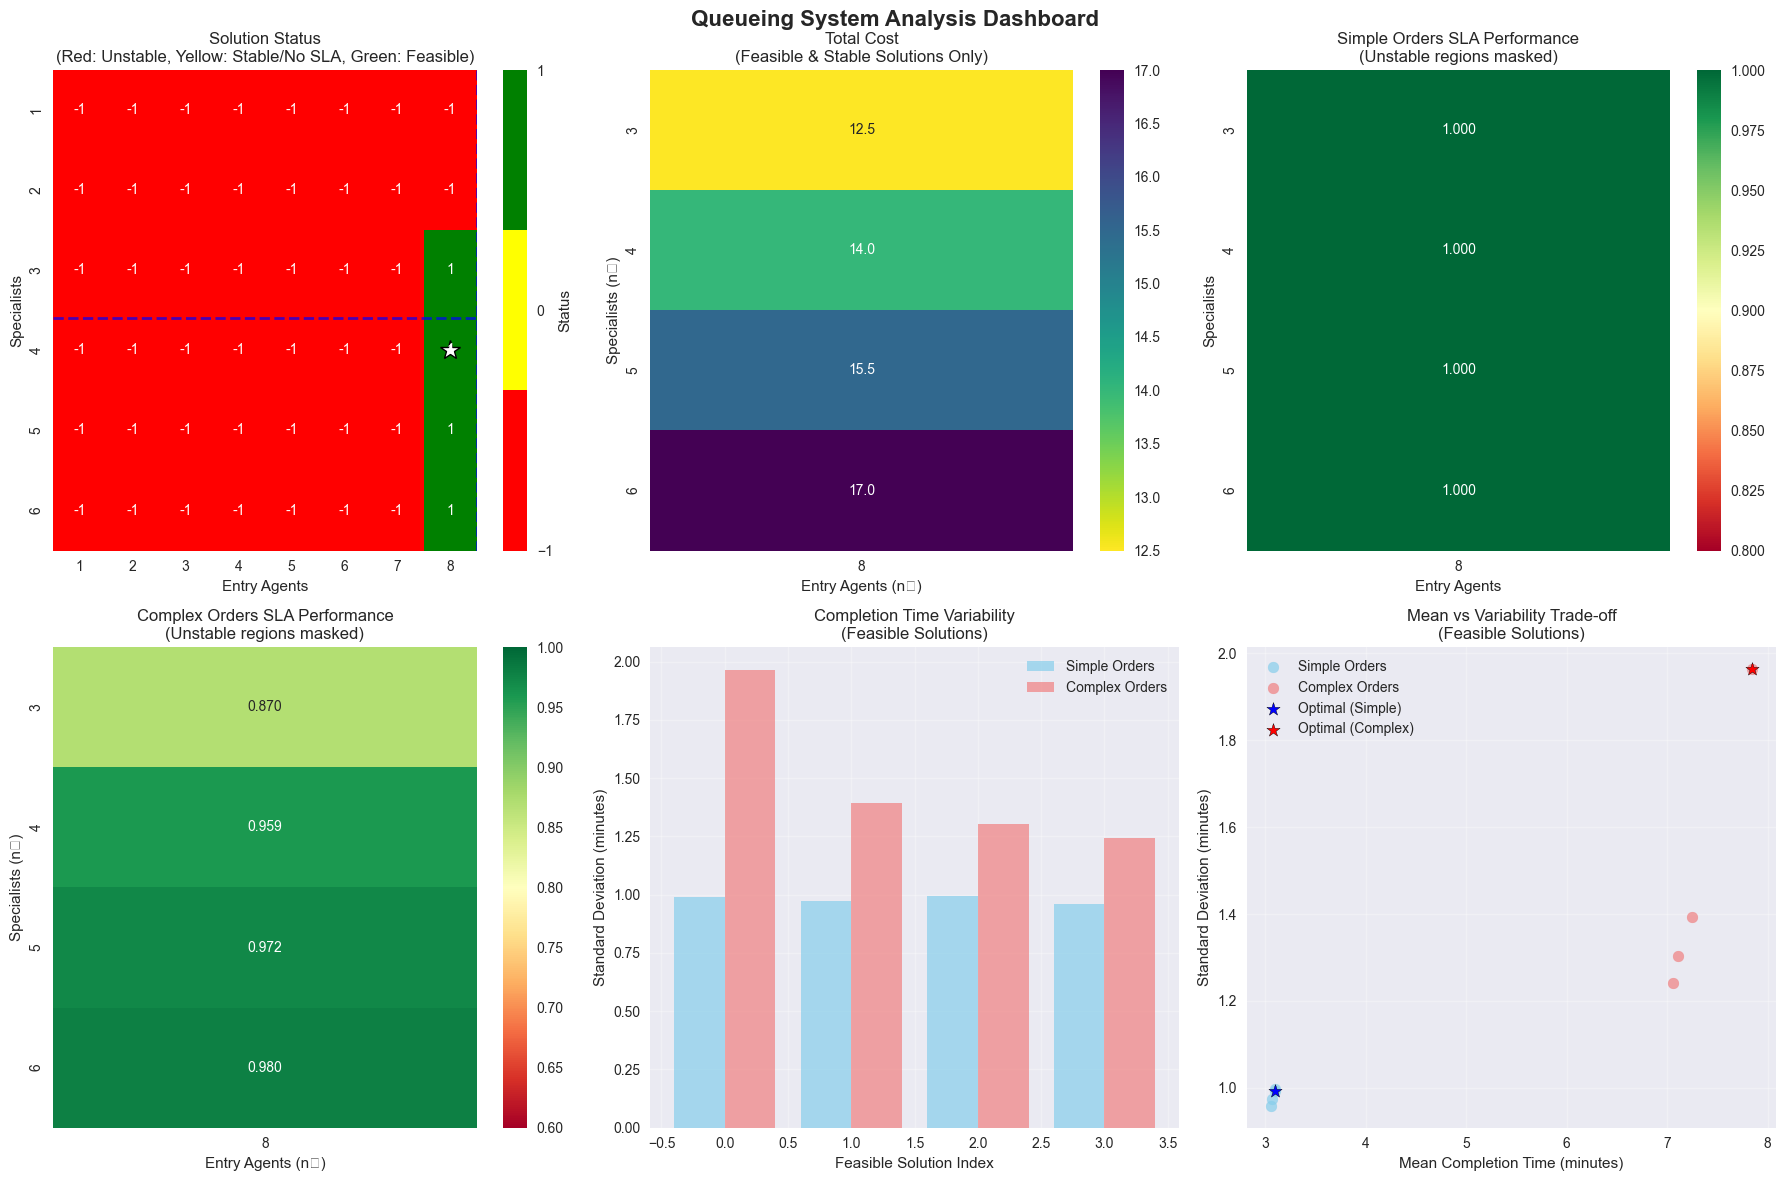

In [70]:
# Create enhanced visualization with stability indicators
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Queueing System Analysis Dashboard', fontsize=16, fontweight='bold')

# Calculate stability boundaries for visualization
min_entry_continuous = base_params.get_minimum_entry_agents()
min_specialist_continuous = base_params.get_minimum_specialists()

# Add all evaluated points to results for comprehensive visualization
all_points = []
for n_entry in range(1, 9):
    for n_specialists in range(1, 7):
        entry_stable, specialist_stable = base_params.is_stable(n_entry, n_specialists)
        system_stable = entry_stable and specialist_stable
        
        # Check if this combination was evaluated
        evaluated = len(all_results[
            (all_results['n_entry'] == n_entry) & (all_results['n_specialists'] == n_specialists)
        ]) > 0
        
        if not evaluated:
            all_points.append({
                'n_entry': n_entry,
                'n_specialists': n_specialists,
                'system_stable': system_stable,
                'both_slas_met': False,
                'simple_sla': 0,
                'complex_sla': 0,
                'total_cost': n_entry * base_params.entry_agent_cost + n_specialists * base_params.specialist_cost
            })

if all_points:
    extended_results = pd.concat([all_results, pd.DataFrame(all_points)], ignore_index=True)
else:
    extended_results = all_results

# 1. Feasible solutions with stability overlay
pivot_feasible = extended_results.pivot(index='n_specialists', columns='n_entry', values='both_slas_met')
pivot_stable = extended_results.pivot(index='n_specialists', columns='n_entry', values='system_stable')

# Convert boolean to numeric and handle NaN values
pivot_feasible = pivot_feasible.fillna(False).astype(int)
pivot_stable = pivot_stable.fillna(False).astype(int)

# Create custom status matrix: -1 (unstable), 0 (stable but no SLA), 1 (feasible)
feasible_with_stability = np.zeros_like(pivot_feasible, dtype=int)
for i in range(len(pivot_stable.index)):
    for j in range(len(pivot_stable.columns)):
        if pivot_stable.iloc[i, j] == 0:  # Unstable
            feasible_with_stability[i, j] = -1
        elif pivot_feasible.iloc[i, j] == 0:  # Stable but no SLA
            feasible_with_stability[i, j] = 0
        else:  # Feasible
            feasible_with_stability[i, j] = 1

# Convert back to DataFrame with same index/columns
feasible_with_stability = pd.DataFrame(feasible_with_stability, 
                                      index=pivot_feasible.index, 
                                      columns=pivot_feasible.columns)

colors = ['red', 'yellow', 'green']
sns.heatmap(feasible_with_stability, annot=True, fmt='.0f', 
           cmap=plt.matplotlib.colors.ListedColormap(colors),
           cbar_kws={'label': 'Status', 'ticks': [-1, 0, 1]}, 
           ax=axes[0,0])
axes[0,0].set_title('Solution Status\n(Red: Unstable, Yellow: Stable/No SLA, Green: Feasible)')
axes[0,0].set_xlabel('Entry Agents')
axes[0,0].set_ylabel('Specialists')

# Add stability boundary lines
axes[0,0].axvline(x=min_entry_continuous + 0.5, color='blue', linestyle='--', alpha=0.7, linewidth=2)
axes[0,0].axhline(y=len(pivot_stable.index) - min_specialist_continuous - 0.5, color='blue', linestyle='--', alpha=0.7, linewidth=2)

# Mark optimal solution if found
if optimal['status'] == 'optimal_found':
    opt_x = optimal['n_entry'] - 0.5
    opt_y = len(pivot_stable.index) - optimal['n_specialists'] + 0.5
    axes[0,0].plot(opt_x, opt_y, 'w*', markersize=15, markeredgecolor='black', markeredgewidth=1)

# 2. Cost heatmap for feasible solutions only
feasible_data = all_results[all_results['both_slas_met'] & all_results['system_stable']]
if not feasible_data.empty:
    pivot_cost = feasible_data.pivot(index='n_specialists', columns='n_entry', values='total_cost')
    sns.heatmap(pivot_cost, annot=True, fmt='.1f', cmap='viridis_r', ax=axes[0,1])
    axes[0,1].set_title('Total Cost\n(Feasible & Stable Solutions Only)')
else:
    axes[0,1].text(0.5, 0.5, 'No Feasible\nSolutions', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('Total Cost (No Feasible Solutions)')
axes[0,1].set_xlabel('Entry Agents (n₁)')
axes[0,1].set_ylabel('Specialists (n₂)')

# 3. Simple SLA performance with stability masking
if not all_results.empty:
    pivot_simple = all_results.pivot(index='n_specialists', columns='n_entry', values='simple_sla')
    # Mask unstable regions
    stable_mask = extended_results.pivot(index='n_specialists', columns='n_entry', values='system_stable')
    stable_mask = stable_mask.fillna(False).astype(bool)
    pivot_simple_masked = pivot_simple.where(stable_mask, np.nan)
    
    sns.heatmap(pivot_simple_masked, annot=True, fmt='.3f', cmap='RdYlGn', 
               vmin=0.8, vmax=1.0, ax=axes[0,2])
    axes[0,2].set_title('Simple Orders SLA Performance\n(Unstable regions masked)')
axes[0,2].set_xlabel('Entry Agents')
axes[0,2].set_ylabel('Specialists')

# 4. Complex SLA performance with stability masking
if not all_results.empty:
    pivot_complex = all_results.pivot(index='n_specialists', columns='n_entry', values='complex_sla')
    pivot_complex_masked = pivot_complex.where(stable_mask, np.nan)
    
    sns.heatmap(pivot_complex_masked, annot=True, fmt='.3f', cmap='RdYlGn', 
               vmin=0.6, vmax=1.0, ax=axes[1,0])
    axes[1,0].set_title('Complex Orders SLA Performance\n(Unstable regions masked)')
axes[1,0].set_xlabel('Entry Agents (n₁)')
axes[1,0].set_ylabel('Specialists (n₂)')

# 5. Standard deviation comparison for feasible solutions
if not feasible_data.empty:
    x_pos = np.arange(len(feasible_data))
    axes[1,1].bar(x_pos - 0.2, feasible_data['simple_std_time'], 0.4, 
                 label='Simple Orders', alpha=0.7, color='skyblue')
    axes[1,1].bar(x_pos + 0.2, feasible_data['complex_std_time'], 0.4, 
                 label='Complex Orders', alpha=0.7, color='lightcoral')
    axes[1,1].set_xlabel('Feasible Solution Index')
    axes[1,1].set_ylabel('Standard Deviation (minutes)')
    axes[1,1].set_title('Completion Time Variability\n(Feasible Solutions)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'No Feasible\nSolutions', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Standard Deviation Analysis')

# 6. Mean vs Standard Deviation scatter plot
if not feasible_data.empty:
    axes[1,2].scatter(feasible_data['simple_mean_time'], feasible_data['simple_std_time'], 
                     alpha=0.7, color='skyblue', s=60, label='Simple Orders')
    axes[1,2].scatter(feasible_data['complex_mean_time'], feasible_data['complex_std_time'], 
                     alpha=0.7, color='lightcoral', s=60, label='Complex Orders')
    
    # Mark optimal solution
    if optimal['status'] == 'optimal_found':
        axes[1,2].scatter(optimal['simple_mean_time'], optimal['simple_std_time'], 
                         color='blue', s=100, marker='*', edgecolors='black', 
                         label='Optimal (Simple)', zorder=5)
        axes[1,2].scatter(optimal['complex_mean_time'], optimal['complex_std_time'], 
                         color='red', s=100, marker='*', edgecolors='black', 
                         label='Optimal (Complex)', zorder=5)
    
    axes[1,2].set_xlabel('Mean Completion Time (minutes)')
    axes[1,2].set_ylabel('Standard Deviation (minutes)')
    axes[1,2].set_title('Mean vs Variability Trade-off\n(Feasible Solutions)')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
else:
    axes[1,2].text(0.5, 0.5, 'No Feasible\nSolutions', ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('Mean vs Standard Deviation Analysis')

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('queueing_optimization_results.png', dpi=300, bbox_inches='tight')
plt.show()

## Sensitivity Analysis Framework

Understanding how our system responds to changes in key parameters is important. The sensitivity analysis in the demo code important dimensions: arrival rate fluctuations (demand uncertainty), service time distribution shapes (modeling assumptions), and service variability (process consistency). 

In [64]:
def sensitivity_analysis_arrival_rate(base_params: SystemParameters, 
                                    arrival_rates: List[float],
                                    n_entry: int, 
                                    n_specialists: int,
                                    n_replications: int = 500) -> pd.DataFrame:
    """Test system response to demand fluctuations"""
    results = []
    
    print(f"\nTesting arrival rate sensitivity with fixed staffing ({n_entry} entry, {n_specialists} specialists)")
    print("Note: Higher rates may violate stability conditions")
    print("-" * 70)
    
    for rate in arrival_rates:
        # Create system with modified arrival rate
        params = SystemParameters(
            arrival_rate=rate,
            simulation_time=base_params.simulation_time,
            entry_service_mean=base_params.entry_service_mean,
            entry_service_variability=base_params.entry_service_variability,
            entry_service_distribution=base_params.entry_service_distribution,
            specialist_service_mean=base_params.specialist_service_mean,
            specialist_service_variability=base_params.specialist_service_variability,
            specialist_service_distribution=base_params.specialist_service_distribution,
            specialist_probability=base_params.specialist_probability
        )
        
        # Check stability at this arrival rate
        entry_stable, specialist_stable = params.is_stable(n_entry, n_specialists)
        
        # Run simulation
        sim = QueueingSimulation(params)
        result = sim.run_simulation(n_entry, n_specialists, n_replications)
        
        results.append({
            'arrival_rate': rate,
            'expected_arrivals': rate * params.simulation_time,
            'simple_sla': result['simple_sla'],
            'complex_sla': result['complex_sla'],
            'simple_mean_time': result['simple_mean_time'],
            'complex_mean_time': result['complex_mean_time'],
            'simple_std_time': result['simple_std_time'],
            'complex_std_time': result['complex_std_time'],
            'entry_stable': entry_stable,
            'specialist_stable': specialist_stable,
            'system_stable': entry_stable and specialist_stable
        })
        
        stability_status = "Stable" if (entry_stable and specialist_stable) else "Unstable"
        print(f"λ = {rate:.2f}: {stability_status:>8} | Simple SLA = {result['simple_sla']:.3f}, Complex SLA = {result['complex_sla']:.3f}")
    
    return pd.DataFrame(results)

def sensitivity_analysis_distribution(base_params: SystemParameters,
                                    distributions: List[DistributionType],
                                    stage: str,
                                    n_entry: int,
                                    n_specialists: int,
                                    n_replications: int = 500) -> pd.DataFrame:
    """Compare performance across service time distributions with fixed E[S]"""
    results = []
    
    mean_service_time = (base_params.entry_service_mean if stage == 'entry' 
                        else base_params.specialist_service_mean)
    
    print(f"\nTesting {stage} service distribution sensitivity (E[S] = {mean_service_time} min fixed)")
    print("-" * 70)
    
    for dist in distributions:
        # Modify only the distribution, keeping mean constant
        if stage == 'entry':
            params = SystemParameters(
                arrival_rate=base_params.arrival_rate,
                entry_service_distribution=dist,
                entry_service_mean=base_params.entry_service_mean,
                entry_service_variability=base_params.entry_service_variability,
                specialist_service_distribution=base_params.specialist_service_distribution,
                specialist_service_mean=base_params.specialist_service_mean,
                specialist_service_variability=base_params.specialist_service_variability
            )
        else:  # specialist
            params = SystemParameters(
                arrival_rate=base_params.arrival_rate,
                entry_service_distribution=base_params.entry_service_distribution,
                entry_service_mean=base_params.entry_service_mean,
                entry_service_variability=base_params.entry_service_variability,
                specialist_service_distribution=dist,
                specialist_service_mean=base_params.specialist_service_mean,
                specialist_service_variability=base_params.specialist_service_variability
            )
        
        sim = QueueingSimulation(params)
        result = sim.run_simulation(n_entry, n_specialists, n_replications)
        
        results.append({
            'distribution': dist.value,
            'stage': stage,
            'simple_sla': result['simple_sla'],
            'complex_sla': result['complex_sla'],
            'simple_mean_time': result['simple_mean_time'],
            'complex_mean_time': result['complex_mean_time'],
            'simple_std_time': result['simple_std_time'],
            'complex_std_time': result['complex_std_time']
        })
        
        print(f"{dist.value:>12}: Simple SLA = {result['simple_sla']:.3f}, Complex SLA = {result['complex_sla']:.3f}")
    
    return pd.DataFrame(results)

def sensitivity_analysis_service_variability(base_params: SystemParameters,
                                           service_variabilities: List[float],
                                           stage: str,
                                           n_entry: int,
                                           n_specialists: int,
                                           n_replications: int = 500) -> pd.DataFrame:
    """Test impact of service time variability with fixed mean and distribution"""
    results = []
    
    print(f"\nTesting {stage} service variability sensitivity (same mean & distribution)")
    print("-" * 70)
    
    for variability in service_variabilities:
        if stage == 'entry':
            params = SystemParameters(
                arrival_rate=base_params.arrival_rate,
                entry_service_variability=variability,
                specialist_service_variability=base_params.specialist_service_variability
            )
        else:
            params = SystemParameters(
                arrival_rate=base_params.arrival_rate,
                entry_service_variability=base_params.entry_service_variability,
                specialist_service_variability=variability
            )
        
        sim = QueueingSimulation(params)
        result = sim.run_simulation(n_entry, n_specialists, n_replications)
        
        results.append({
            'service_variability': variability,
            'stage': stage,
            'simple_sla': result['simple_sla'],
            'complex_sla': result['complex_sla'],
            'simple_mean_time': result['simple_mean_time'],
            'complex_mean_time': result['complex_mean_time'],
            'simple_std_time': result['simple_std_time'],
            'complex_std_time': result['complex_std_time']
        })
        
        print(f"CV = {variability:.2f}: Simple SLA = {result['simple_sla']:.3f}, Complex SLA = {result['complex_sla']:.3f}")
    
    return pd.DataFrame(results)

print("Sensitivity analysis framework ready for comprehensive parameter testing.")

Sensitivity analysis framework ready for comprehensive parameter testing.


## Sensitivity Analysis

We now conduct a thorough sensitivity analysis using our optimal staffing solution. This reveals how robust our solution is to changes in key parameters and helps identify which assumptions are most critical for system performance.


In [65]:
# Use optimal solution for sensitivity analysis
if optimal['status'] == 'optimal_found':
    opt_entry = optimal['n_entry']
    opt_specialists = optimal['n_specialists']
else:
    # Use reasonable defaults based on stability requirements
    opt_entry = max(4, int(np.ceil(base_params.get_minimum_entry_agents())))
    opt_specialists = max(3, int(np.ceil(base_params.get_minimum_specialists())))

print(f"SENSITIVITY ANALYSIS")
print(f"Using staffing: {opt_entry} entry agents, {opt_specialists} specialists")
print("=" * 60)

# 1. Arrival rate sensitivity (including potentially unstable rates)
arrival_rates = [2.5, 3.0, 3.5, 4.0, 4.5]  # Some may violate stability
arrival_sensitivity = sensitivity_analysis_arrival_rate(
    base_params, arrival_rates, opt_entry, opt_specialists, n_replications=300
)

# 2. Distribution shape sensitivity
test_distributions = [DistributionType.NORMAL, DistributionType.EXPONENTIAL, 
                     DistributionType.UNIFORM, DistributionType.GAMMA]

entry_dist_sensitivity = sensitivity_analysis_distribution(
    base_params, test_distributions, 'entry', opt_entry, opt_specialists, n_replications=300
)

specialist_dist_sensitivity = sensitivity_analysis_distribution(
    base_params, test_distributions, 'specialist', opt_entry, opt_specialists, n_replications=300
)

# 3. Service variability sensitivity
service_variabilities = [0.1, 0.2, 0.3, 0.4, 0.5]
entry_var_sensitivity = sensitivity_analysis_service_variability(
    base_params, service_variabilities, 'entry', opt_entry, opt_specialists, n_replications=300
)

print("\nSensitivity analysis complete. Results ready for visualization.")

SENSITIVITY ANALYSIS
Using staffing: 8 entry agents, 3 specialists

Testing arrival rate sensitivity with fixed staffing (8 entry, 3 specialists)
Note: Higher rates may violate stability conditions
----------------------------------------------------------------------
λ = 2.50:   Stable | Simple SLA = 1.000, Complex SLA = 0.948
λ = 3.00:   Stable | Simple SLA = 1.000, Complex SLA = 0.873
λ = 3.50: Unstable | Simple SLA = 0.999, Complex SLA = 0.763
λ = 4.00: Unstable | Simple SLA = 0.987, Complex SLA = 0.634
λ = 4.50: Unstable | Simple SLA = 0.955, Complex SLA = 0.479

Testing entry service distribution sensitivity (E[S] = 2.5 min fixed)
----------------------------------------------------------------------
      normal: Simple SLA = 1.000, Complex SLA = 0.879
 exponential: Simple SLA = 0.976, Complex SLA = 0.722
     uniform: Simple SLA = 1.000, Complex SLA = 0.870
       gamma: Simple SLA = 1.000, Complex SLA = 0.892

Testing specialist service distribution sensitivity (E[S] = 4.0 min

## Sensitivity Analysis Visualization

These visualizations show how our system performance changes with different parameter values, helping us understand the robustness of our optimal solution and identify critical assumptions.

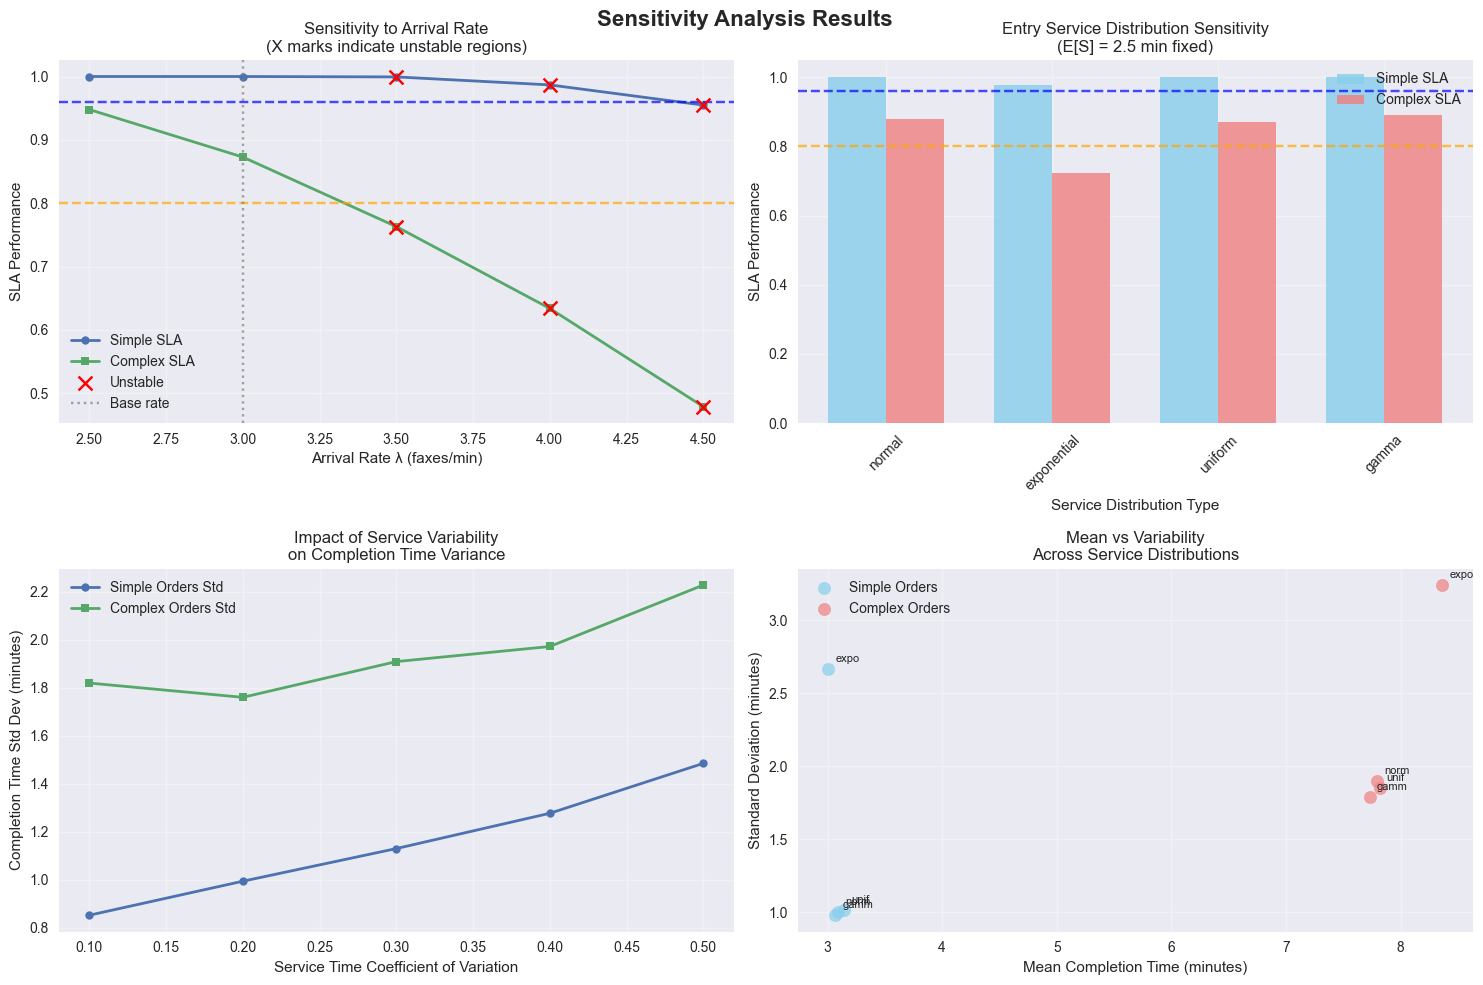

In [68]:
# Create sensitivity analysis visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sensitivity Analysis Results', fontsize=16, fontweight='bold')

# 1. Arrival rate sensitivity with stability indicators
axes[0,0].plot(arrival_sensitivity['arrival_rate'], arrival_sensitivity['simple_sla'], 
              'o-', label='Simple SLA', linewidth=2, markersize=6)
axes[0,0].plot(arrival_sensitivity['arrival_rate'], arrival_sensitivity['complex_sla'], 
              's-', label='Complex SLA', linewidth=2, markersize=6)

# Mark unstable points
unstable_rates = arrival_sensitivity[~arrival_sensitivity['system_stable']]
if not unstable_rates.empty:
    axes[0,0].scatter(unstable_rates['arrival_rate'], unstable_rates['simple_sla'], 
                     color='red', s=100, marker='x', label='Unstable', zorder=5)
    axes[0,0].scatter(unstable_rates['arrival_rate'], unstable_rates['complex_sla'], 
                     color='red', s=100, marker='x', zorder=5)

axes[0,0].axhline(y=base_params.simple_sla_target, color='blue', linestyle='--', alpha=0.7)
axes[0,0].axhline(y=base_params.complex_sla_target, color='orange', linestyle='--', alpha=0.7)
axes[0,0].axvline(x=base_params.arrival_rate, color='gray', linestyle=':', alpha=0.7, label='Base rate')
axes[0,0].set_xlabel('Arrival Rate λ (faxes/min)')
axes[0,0].set_ylabel('SLA Performance')
axes[0,0].set_title('Sensitivity to Arrival Rate\n(X marks indicate unstable regions)')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Distribution sensitivity comparison
x_pos = np.arange(len(entry_dist_sensitivity))
width = 0.35
axes[0,1].bar(x_pos - width/2, entry_dist_sensitivity['simple_sla'], width, 
             label='Simple SLA', alpha=0.8, color='skyblue')
axes[0,1].bar(x_pos + width/2, entry_dist_sensitivity['complex_sla'], width, 
             label='Complex SLA', alpha=0.8, color='lightcoral')

axes[0,1].axhline(y=base_params.simple_sla_target, color='blue', linestyle='--', alpha=0.7)
axes[0,1].axhline(y=base_params.complex_sla_target, color='orange', linestyle='--', alpha=0.7)
axes[0,1].set_xlabel('Service Distribution Type')
axes[0,1].set_ylabel('SLA Performance')
axes[0,1].set_title('Entry Service Distribution Sensitivity\n(E[S] = 2.5 min fixed)')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(entry_dist_sensitivity['distribution'], rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Service variability impact on standard deviation
axes[1,0].plot(entry_var_sensitivity['service_variability'], entry_var_sensitivity['simple_std_time'], 
              'o-', label='Simple Orders Std', linewidth=2, markersize=6)
axes[1,0].plot(entry_var_sensitivity['service_variability'], entry_var_sensitivity['complex_std_time'], 
              's-', label='Complex Orders Std', linewidth=2, markersize=6)
axes[1,0].set_xlabel('Service Time Coefficient of Variation')
axes[1,0].set_ylabel('Completion Time Std Dev (minutes)')
axes[1,0].set_title('Impact of Service Variability\non Completion Time Variance')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. Mean vs Std comparison across distributions
axes[1,1].scatter(entry_dist_sensitivity['simple_mean_time'], entry_dist_sensitivity['simple_std_time'], 
                 s=80, alpha=0.7, color='skyblue', label='Simple Orders')
axes[1,1].scatter(entry_dist_sensitivity['complex_mean_time'], entry_dist_sensitivity['complex_std_time'], 
                 s=80, alpha=0.7, color='lightcoral', label='Complex Orders')

# Add distribution labels
for i, row in entry_dist_sensitivity.iterrows():
    axes[1,1].annotate(row['distribution'][:4], 
                      (row['simple_mean_time'], row['simple_std_time']), 
                      xytext=(5, 5), textcoords='offset points', fontsize=8)
    axes[1,1].annotate(row['distribution'][:4], 
                      (row['complex_mean_time'], row['complex_std_time']), 
                      xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[1,1].set_xlabel('Mean Completion Time (minutes)')
axes[1,1].set_ylabel('Standard Deviation (minutes)')
axes[1,1].set_title('Mean vs Variability\nAcross Service Distributions')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.savefig('sensitivity_analysis_results.png', dpi=300, bbox_inches='tight')
plt.show()
